In [1]:
import numpy as np
import tensorflow as tf
import math
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers

from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

C:\Users\laura\anaconda3\envs\Dissertation\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\laura\anaconda3\envs\Dissertation\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\laura\anaconda3\envs\Dissertation\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\laura\anaconda3\envs\Dissertation\lib\site-

Now we imported all the libraries that we need for our model. Next, we show how we can model random stock price trajectories within the Black Scholes model, by using the property that B-S stock prices have lognormal increments. 
Additionally, all important parameters are initialised.

1.0613937859188571
0.131519073177428


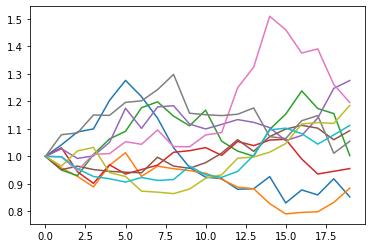

In [2]:
# Trajectories of the Black scholes model
# Let it run to initialize the following parameters, the trajectories 
# are not needed afterwards

N=20 # time disrectization
S0=1 # initial value of the asset
strike=1 # strike for the call option 
T=1.0 # maturity
sigma=0.2 # volatility in Black Scholes
R=10 # number of Trajectories

logS= np.zeros((N,R))
logS[0,]=np.log(S0)*np.ones((1,R))

for i in range(R):
    for j in range(N-1):
        increment = np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N))
        logS[j+1,i] =logS[j,i]+increment

S=np.exp(logS)
#added to compare it with the X dynamics in the portfolio maximization model
print(np.mean(S[N-1,:]))
print(np.std(S[N-1,:]))

for i in range(R):
   plt.plot(S[:,i])
plt.show()

We define the black scholes price of a European call option at t=0.

In [3]:
import scipy.stats as scipy
from scipy.stats import norm

#Blackscholes price

def BS(S0, strike, T, sigma):
    return S0*scipy.norm.cdf((np.log(S0/strike)+0.5*T*sigma**2)/(np.sqrt(T)*sigma))-strike*scipy.norm.cdf((np.log(S0/strike)-0.5*T*sigma**2)/(np.sqrt(T)*sigma))

priceBS=BS(S0,strike,T,sigma)
print('Price of a Call option in the Black scholes model with initial price', 
      S0, 'strike', strike, 'maturity', T , 'and volatility' , sigma, 'is equal to', BS(S0,strike,T,sigma))

Price of a Call option in the Black scholes model with initial price 1 strike 1 maturity 1.0 and volatility 0.2 is equal to 0.07965567455405798


Here we define the structure of the neural networks, choosing the number of layers and the number of neurons.
The hidden layers have the hypertolic tangent function as their activation function, 
the weights and bias are randomly determined and the final layer uses a linear function to calculate the output.

In [4]:
#Definition of neural networks for hedging strategies

m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 8  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

Plot the hyperbolic tangent function.

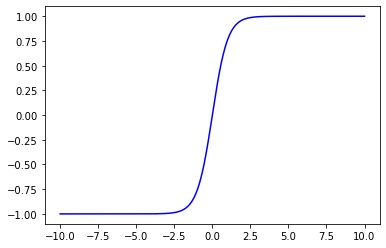

In [5]:
import matplotlib.pyplot as plt
h=np.linspace(-10,10,2000)
v= np.tanh(h)
plt.plot(h,v,'b')
plt.show()


Finally, we build the algorithm, with a neural network for each time interval and four input vectors with the initial prices and hedges and the BS price increments. 
The output of the model consists of 22 vectors (for N=20), the first vector is the loss, the next 20 are all the optimal hedigng strategies for each time interval and the final vector is the BS price of the option.

In [6]:
#Implementing the loss function
# Inputs is the training set below, containing the price S0, 
#the initial hedging being 0, and the increments of the log price process 
price = Input(shape=(m,))
hedge = Input(shape=(m,))
hedgeeval = Input(shape=(m,))
premium = Input(shape=(m,))

inputs = [price]+[hedge]+[hedgeeval]+[premium]
outputhelper=[]

premium = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                bias_initializer=initializers.RandomNormal(0,1))(premium)

for j in range(N):
    strategy = price
    strategyeval=hedgeeval
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
        strategyeval=layers[k+(j)*d](strategyeval)
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)# creating the price at time j+1
    priceincr=Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge = Add()([hedge,hedgenew]) # building up the discretized stochastic integral
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval]
    price=pricenew
payoff= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike))(price) 
outputs = Subtract()([payoff,hedge]) 
outputs = Subtract()([outputs,premium]) # payoff minus price minus hedge 
outputs= [outputs] + outputhelper +[premium]
print(len(outputs))
print(len(outputhelper))
outputs = Concatenate()(outputs)

model_hedge_strat = Model(inputs=inputs, outputs=outputs)

22
20


Using the summary function, we can see the number of parameters in the model.

In [7]:
model_hedge_strat.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
add_1 (Add)                     (None, 1)            0           lambda_1[0][0]                   
                                                                 input_5[0][0]              

We define the training data with 100.000 training points, and all the input vectors as defined in the model structure.
ytrain is an array with 21 columns, all zeroes, because we are aiming for a hedge that is as low as possible.

In [8]:
Ktrain = 10**5
initialprice = S0

# xtrain consists of the price S0, 
#the initial hedging being 0, and the increments of the log price process 
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [np.ones((Ktrain,m))] +
          [priceBS*np.ones((Ktrain,m))]+
          [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])
print(len(xtrain))

ytrain=np.zeros((Ktrain,1+N))

24


This is the custom loss function, which is the mean squared difference between the true y and the predicted y.

In [9]:
#import keras
from keras import losses
def custom_loss(y_true,y_pred):
    #return losses.mean_squared_error(y_true[0], y_pred[0])
    z = y_pred[:,0]-y_true[:,0]
    z=K.mean(K.square(z))
    return z

This is the compilation of the model, where we choose the optimizer Adam which is a more complicated version of the stochastic gradient descent algorithm with an adaptive learning rate. Using the first two lines, it is possible to change the learning rate from the default rate 0.001.

In [10]:
#from keras import optimizers
#adam=optimizers.Adam(lr=0.0005)

model_hedge_strat.compile(optimizer='adam',loss=custom_loss)

Now, we fit the model on the training data.

Increase 5 to 50.

In [11]:
import matplotlib.pyplot as plt

for i in range(5):
    model_hedge_strat.fit(x=xtrain,y=ytrain, epochs=1,verbose=True)



Epoch 1/1
100000/100000 [==============================] - 18s 182us/step - loss: 0.3083
Epoch 1/1
100000/100000 [==============================] - 17s 167us/step - loss: 8.0463e-04
Epoch 1/1
100000/100000 [==============================] - 18s 178us/step - loss: 4.0598e-04
Epoch 1/1
100000/100000 [==============================] - 18s 184us/step - loss: 3.3250e-04
Epoch 1/1
100000/100000 [==============================] - 19s 193us/step - loss: 2.9679e-04


make xtest exactly the same as xtrain but then half the size

this is the same histogram with the plotted loss as in the first model, so we want it close to zero

We print the mean and sd of the loss, then we print the mean and standard deviation of the B-S price of the option. The price is the same as when we calculate it directly (and not run it through the neural network as an extra input). The standard deviation is negligble, as it should be. 

The test data is made the exact same as the training data, and similar to how we define test data in the earlier model in Teichmann's jupyter notebook.

Are we not also interested in the hedge per time interval? Do that next!

In [12]:
def BS(S0, strike, T, sigma):
    return S0*scipy.norm.cdf((np.log(S0/strike)+0.5*T*sigma**2)/(np.sqrt(T)*sigma))-strike*scipy.norm.cdf((np.log(S0/strike)-0.5*T*sigma**2)/(np.sqrt(T)*sigma))

priceBS=BS(S0,strike,T,sigma)
print('Price of a Call option in the Black scholes model with initial price', 
      S0, 'strike', strike, 'maturity', T , 'and volatility' , sigma, 'is equal to', BS(S0,strike,T,sigma))

Price of a Call option in the Black scholes model with initial price 1 strike 1 maturity 1.0 and volatility 0.2 is equal to 0.07965567455405798


24
1100000


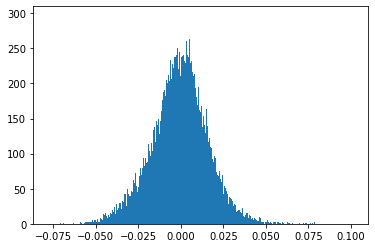

mean of loss is -0.0009922786
standard deviation of loss is 0.01657603
mean of BS-price is 0.080780506
standard deviation of BS-price is 0.0


In [13]:
Ktest1 = 50000
xtest1 = ([initialprice*np.ones((Ktest1,m))] +
          [np.zeros((Ktest1,m))]+
          [np.ones((Ktest1,m))] +
          [priceBS*np.ones((Ktest1,m))]+
          [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktest1,m)) for i in range(N)])
y_test1 = model_hedge_strat.predict(xtest1)
print(len(xtest1))
print(y_test1.size)
plt.hist(y_test1[:,0], bins=1000)
plt.show()
print('mean of loss is', np.mean(y_test1[:,0]))
print('standard deviation of loss is', np.std(y_test1[:,0]))
print('mean of BS-price is', np.mean(y_test1[:, N+1]))
print('standard deviation of BS-price is', np.std(y_test1[:, N+1]))


Here, we print out the list of hedges for each time interval up to N and print out a graph of the hedges with the time intervals on the x axis.

[0.5160341, 0.5448332, 0.5424166, 0.5796757, 0.5628444, 0.56622595, 0.5392403, 0.5514822, 0.52687025, 0.542963, 0.5416055, 0.5126453, 0.5562934, 0.5284863, 0.5430693, 0.5289727, 0.5504941, 0.5166616, 0.5154399, 0.47521216]


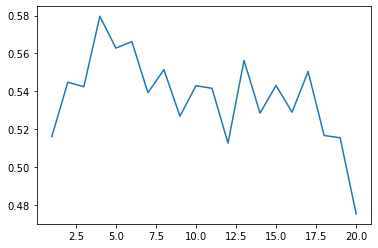

In [14]:
hedge_list = []
for i in range(N):
    hedge_list.append(np.mean(y_test1[:,1+i]))
print(hedge_list)
#now plot the hedges per time interval in a graph
time = np.linspace(1,N, N)
plt.plot(time,hedge_list)

this is  how Teichmann defined his test data: seems like the third vector, where we have a linspace from 0.5 to 1.5 instead of a bunch of ones, this is the initital hedge evaluation that we put through the neural network layers. but somehow it is also the same as how the stock price is calculated for plotting the hedge and stockprice for a specific time interval

Teichmann comments to change it for higher dimensions, since then we would have m >1 instead of m=1 which is taken into account for the other input vectors in the test data. so is the hedgeeval determined around the stockprice? But is that not dependent on the trajectory of the stockprice over the time intervals.

In [32]:
Ktest= 10
xtest = ([initialprice*np.ones((Ktest,m))] +
          [np.zeros((Ktest,m))]+
          [np.linspace(0.5,1.5,Ktest)] +#change this if you go to higher dimensions
          [priceBS*np.ones((Ktest,m))]+
          [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktest,m)) for i in range(N)])
y_whole = model_hedge_strat.predict(xtest)
y = y_whole[:,1]
print(y)

[0.46407422 0.48033977 0.49325737 0.5036833  0.5122746  0.51949704
 0.52567255 0.53102666 0.53572136 0.5398759 ]


does it make sense for stockprices to be within 0.5 and 1.5? when data trained on volatility of 0.2
the stock prices (from 0.5 - 1.5) are plotted on the horizontal axis, with the delta hedge on the vertical axis. This is both the Black-Scholes hedge N(d1) and the neural network prediction

We are plotting time interval 9 (i.e. l =9 and column 10 in y). Also try another time interval.

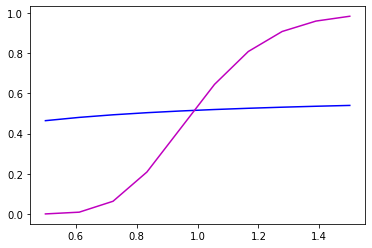

In [33]:
l = 0
s=np.linspace(0.5,1.5,Ktest)
z=scipy.norm.cdf((np.log(s/strike)+0.5*(T-l*T/N)*sigma**2)/(np.sqrt(T-l*T/N)*sigma))
plt.plot(s,y,'b',s,z,'m')
plt.show()

In [258]:
#list_of_y = [list_of_y[0]]
list_of_y.append(y)

In [259]:
print(list_of_y)

[array([-0.18912683, -0.1290241 , -0.04272655,  0.12012804,  0.38623962,
        0.66145265,  0.83785427,  0.9279225 ,  0.97201574,  0.9924954 ],
      dtype=float32), array([-0.5215476 , -0.44479057, -0.3569849 , -0.25768942, -0.14717874,
       -0.02674985,  0.10109422,  0.2327163 ,  0.3637366 ,  0.4896713 ,
        0.60661566,  0.71174717,  0.8035254 ,  0.8816009 ,  0.9465426 ,
        0.9995144 ,  1.0419863 ,  1.0755173 ,  1.1016134 ,  1.1216472 ],
      dtype=float32)]


In [ ]:
print(y_whole[:,2])
new_y = np.delete(y_whole, 21, 1)
new_y = np.delete(new_y, 0, 1)
df_g = pd.DataFrame(new_y)
df_g.to_csv('dataframe.csv'